In [188]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import FTestAnovaPower
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import dill
import pingouin as pg
import data_visualization as dv
import analysis_utilities as au
from analysis_utilities import Bootstrap
import importlib

# Initial Thangs

In [189]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Boostrap Function

In [190]:
def bootstrap(metric,plot=True):
    mdt_1000  = np.concatenate((metric[:,0],metric[:,1]))
    mdt_1100  = np.concatenate((metric[:,2],metric[:,3]))
    mdt_1200  = np.concatenate((metric[:,4],metric[:,5]))


    # Mean differences original
    diff_a = mdt_1000 - mdt_1100
    diff_b = mdt_1000 - mdt_1200
    diff_c = mdt_1100 - mdt_1200
    mean_diffa, mean_diffb, mean_diffc = np.mean(diff_a),np.mean(diff_b),np.mean(diff_c)

    # Mean differences normalized around 0
    diff0 = diff_a - mean_diffa
    diff1 = diff_b - mean_diffb
    diff2 = diff_c - mean_diffc
    mean_diff0,mean_diff1,mean_diff2 = np.mean(diff0),np.mean(diff1),np.mean(diff1)
    mean_diff_list = [mean_diff0,mean_diff1,mean_diff2]
    boot_m = 10000
    boot_diff_matrix = np.empty((3,boot_m))
    for i in range(boot_m):
        data_boot0 = np.random.choice(diff0,size=len(diff0),replace=True)
        data_boot1 = np.random.choice(diff1,size=len(diff1),replace=True)
        data_boot2 = np.random.choice(diff2,size=len(diff2),replace=True)
        boot_diff_matrix[0,i] = np.mean(data_boot0)
        boot_diff_matrix[1,i] = np.mean(data_boot1)
        boot_diff_matrix[2,i] = np.mean(data_boot2)
    c_arr = np.array([0,0,0])
    original_mean_diffs = [abs(mean_diffa),abs(mean_diffb),abs(mean_diffc)]
    # How many times did we get a test statsitic from the bootstrap that was larger (smaller) than the original mean diff (or neg mean diff)
    for i in range(3):
        for j in range(boot_m):
            if boot_diff_matrix[i,j]<original_mean_diffs[i]*-1:
                c_arr[i]+=1
            if boot_diff_matrix[i,j]>original_mean_diffs[i]:
                c_arr[i]+=1
    pvals = np.array(c_arr)/boot_m
    print(pvals)


    conf_up0 = np.quantile(boot_diff_matrix[0],0.975)
    conf_down0 = np.quantile(boot_diff_matrix[0],0.025)
    conf_up1 = np.quantile(boot_diff_matrix[1],0.975)
    conf_down1 = np.quantile(boot_diff_matrix[1],0.025)
    conf_up2 = np.quantile(boot_diff_matrix[2],.975)
    conf_down2 = np.quantile(boot_diff_matrix[2],0.025)

    conf_ups = [conf_up0,conf_up1,conf_up2]
    conf_downs = [conf_down0,conf_down1,conf_down2]
    
    if plot:
        titles = ['Mean Difference 1000 - 1100','Mean Difference 1000 - 1200','Mean Difference 1100 - 1200']
        i=-1
        for ciu,cid in zip(conf_ups,conf_downs):
            i+=1
            fig,ax = plt.subplots(dpi=125,figsize=(8,4))
            ax.hist(boot_diff_matrix[i],bins=50,color=wheel.dark_grey,zorder=0)
            ax.axvline(original_mean_diffs[i],c=wheel.rak_orange)
            ax.axvline(-original_mean_diffs[i],c=wheel.rak_orange)
            # ax.axvline(ciu,c=wheel.rak_red)
            # ax.axvline(cid,c=wheel.rak_red)
            ax.axvline(np.median(boot_diff_matrix[i]),c=wheel.rak_blue)
            ax.set_ylabel('Counts')
            ax.set_xlabel('Bootstrapped Median\nDecision Time Difference (ms)')
            ax.set_title(titles[i])
            ax.text(-original_mean_diffs[i],500,f'P={pvals[i]}')
            dv.Custom_Legend(ax,['Mean Differences','Bootstrapped Median'],[wheel.rak_orange,wheel.rak_blue])


# Pickle

In [191]:
NUM_STDS = 2
append_dict = {0:'reaction_time_no_sd_off',1:'reaction_time_minus_sd',2:'reaction_time_minus_2sd'}
load_path = r'D:\Subject_Data\Seth_MatchPennies_Agent_Exp1\Subjects_Analyzed\\'
subject = dill.load((open(load_path + f'subject_object_{append_dict[NUM_STDS]}_dict.pkl', 'rb')))
group   = dill.load((open(load_path + f'group_object_{append_dict[NUM_STDS]}.pkl', 'rb')))
group.analyze_data()
num_subjects = len(subject.keys())

c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:555: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_wins_mean                      = np.nanmean(self.combine_all_subjects('perc_binned_player_wins'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:556: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_indecisions_mean               = np.nanmean(self.combine_all_subjects('perc_binned_player_indecisions'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:557: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_incorrects_mean                = np.nanmean(self.combine_all_subjects('perc_binned_player_incorrects'),axis

# Power Analysis

In [192]:
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=0.5,power=0.8,alpha=0.05)


In [193]:
analysis = FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=0.5,nobs=None,alpha=0.05,power=0.8,k_groups=6)
sample_size

57.10661888657371

# Create DataFrame for Pingouin

In [194]:
wins = group.combine_all_subjects('player_perc_wins').flatten().tolist()
indecisions = group.combine_all_subjects('player_perc_indecisions').flatten().tolist()
incorrects = group.combine_all_subjects('player_perc_incorrects').flatten().tolist()
leave_times = group.combine_all_subjects('player_task_leave_time_median').flatten().tolist()
subject_number = np.repeat(np.arange(1,21,1,dtype=int),6).tolist()
alt_condition = np.tile(['1000 (50)','1000 (150)','1100 (50)','1100 (150)', '1200 (50)', '1200 (150)'],num_subjects).tolist()
condition_mean = np.tile(['1000','1000','1100','1100','1200','1200'],num_subjects)
condition_sd = np.tile(['50','150'],num_subjects*3)
condition = np.tile(np.arange(1,7,1,dtype=int),num_subjects).tolist()
df = pd.DataFrame(np.array([subject_number,condition,condition_mean,condition_sd,leave_times,wins,indecisions,incorrects]).T,columns=['Subject','Condition','Condition Mean','Condition SD','Median Decision Time','Wins','Indecisions','Incorrects'])
df = df.astype('float64')
df = df.astype({'Subject':'int32','Condition':'int32','Condition Mean':'int32','Condition SD':'int32'})
df

,Subject,Condition,Condition Mean,Condition SD,Median Decision Time,Wins,Indecisions,Incorrects
0,1,1,1000,50,1197.5,58.75,3.75,37.50
1,1,2,1000,150,1211.5,70.00,17.50,12.50
2,1,3,1100,50,1268.0,53.75,16.25,30.00
3,1,4,1100,150,1166.0,53.75,5.00,41.25
4,1,5,1200,50,1165.5,42.50,3.75,53.75
...,...,...,...,...,...,...,...,...
115,20,2,1000,150,970.0,50.00,8.75,41.25
116,20,3,1100,50,1089.0,47.50,13.75,38.75
117,20,4,1100,150,1059.0,51.25,13.75,35.00
118,20,5,1200,50,1053.5,43.75,8.75,47.50


## Filter dataframe for means and std

In [195]:
mean_df = df[df['Condition']%2!=0] # Fitler to get condition 1 3 5 which are the means

df_1000 = df[df['Condition']<=2]

df_1100 = df[(df['Condition']<=4) & (df['Condition']>2)]

df_1200 = df[df['Condition']>4]

## RM Anova

Is the median decision time different between the 3 conditions (mean)?

$H_{0}$: true median decision times are the same for all 3 conditions

$H_{1}$: true median decision times are no the same for all 3 conditions

#### Task Decision Time Mean

RM Anova Between Means

In [196]:
pg.rm_anova(data=df, dv='Median Decision Time', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,58937.112500,2,38,29468.556250,4.529204,0.017210,0.026786,0.032825,0.777894
1,Condition SD,65030.352083,1,19,65030.352083,6.832218,0.017073,0.017073,0.036096,1.000000
2,Condition Mean * Condition SD,2199.329167,2,38,1099.664583,0.431413,0.652732,0.615635,0.001265,0.826455


Follow-up Mean Comparisons

In [197]:
pg.pairwise_tests(data=df, dv='Median Decision Time', parametric=False, within=['Condition Mean','Condition SD'], subject='Subject',correction='auto',padjust='holm')

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\pingouin\pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
c:\Users\Seth Sullivan\anaconda3\lib\site-packages\pingouin\pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
c:\Users\Seth Sullivan\anaconda3\lib\site-packages\pingouin\pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.col

,Contrast,Condition Mean,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Condition Mean,-,1000.0,1100.0,True,False,13.0,two-sided,0.000168,0.000504,holm,-0.464154
1,Condition Mean,-,1000.0,1200.0,True,False,93.0,two-sided,0.674223,0.674223,holm,-0.051955
2,Condition Mean,-,1100.0,1200.0,True,False,46.0,two-sided,0.026642,0.053284,holm,0.401951
3,Condition SD,-,50.0,150.0,True,False,25.0,two-sided,0.001690,NaN,NaN,0.412901
4,Condition Mean * Condition SD,1000,50,150,True,False,26.0,two-sided,0.005841,0.017522,holm,0.269217
5,Condition Mean * Condition SD,1100,50,150,True,False,59.0,two-sided,0.089695,0.089695,holm,0.463211
6,Condition Mean * Condition SD,1200,50,150,True,False,45.0,two-sided,0.023951,0.047901,holm,0.406014


Bootstrap Median Decision Time Comparisons

In [198]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
Bootstrap(data1,data2)

0.0547

[0.0039 0.5288 0.0073]


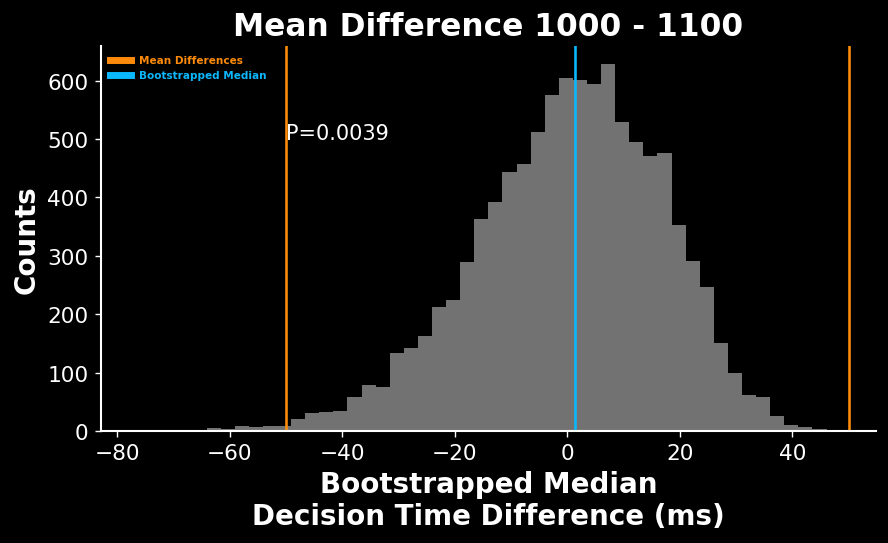

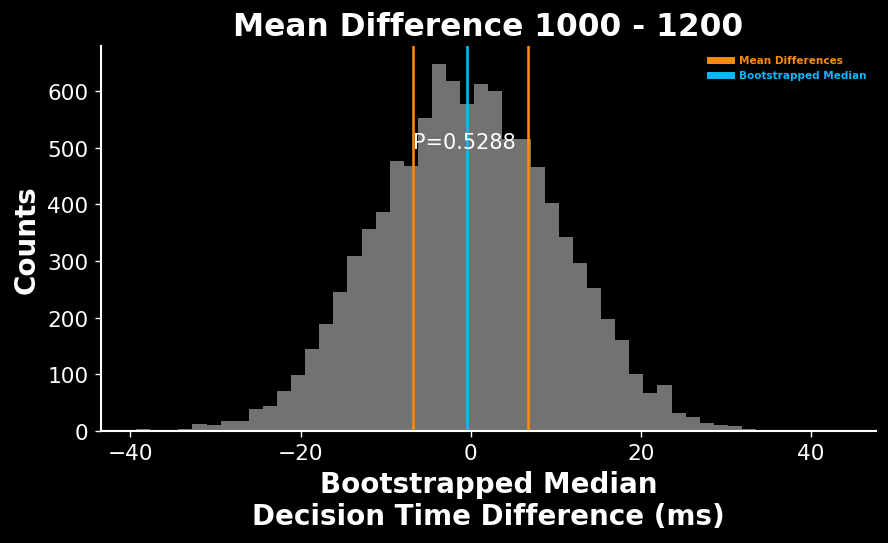

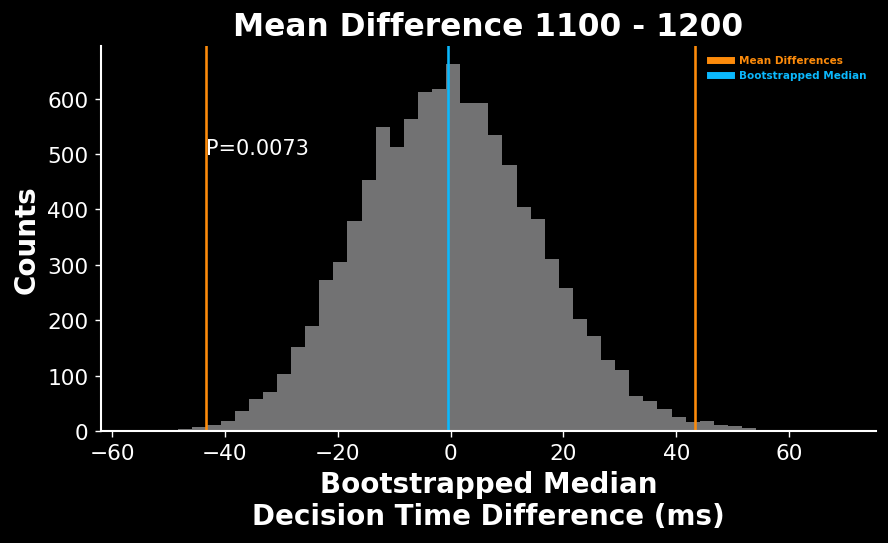

In [199]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
bootstrap(metric)
    

#### Wins

Anova

In [200]:
pg.rm_anova(data=df, dv='Wins', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,13373.671875,2,38,6686.835938,51.777019,1.407231e-11,2.670757e-09,0.501585,0.759118
1,Condition SD,579.700521,1,19,579.700521,8.951407,7.495068e-03,7.495068e-03,0.041799,1.000000
2,Condition Mean * Condition SD,2636.119792,2,38,1318.059896,23.729079,2.053863e-07,3.546155e-06,0.165531,0.770944


Bootstrap ttests

In [201]:
metric    = group.combine_all_subjects('player_wins')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
Bootstrap(data1,data2)

0.0

[0.     0.     0.0001]


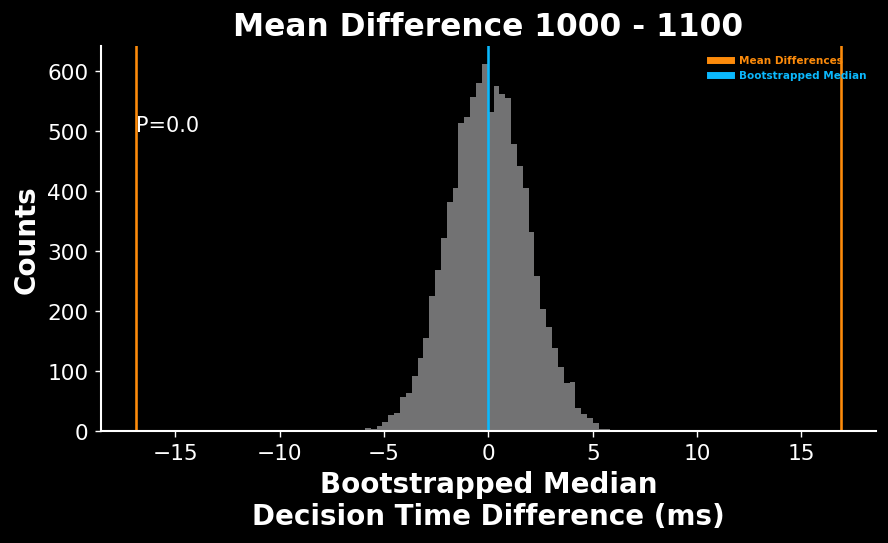

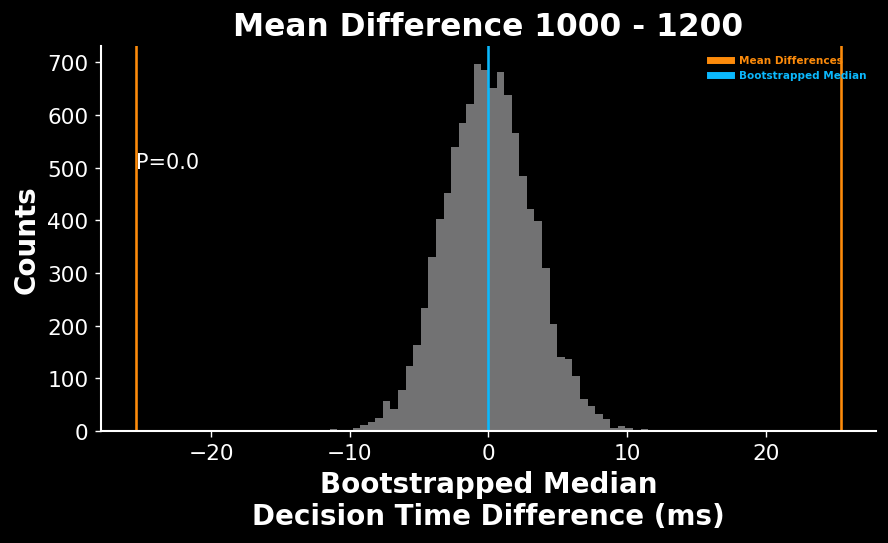

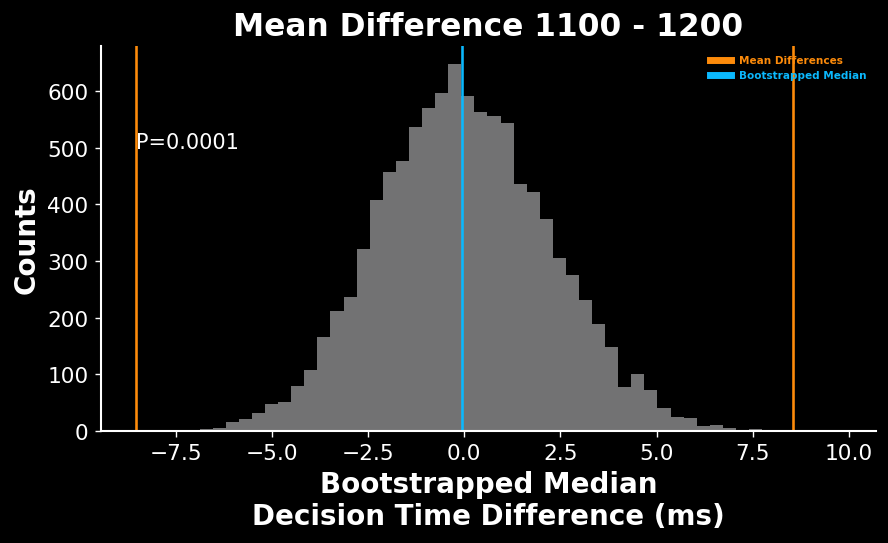

In [202]:
metric = group.combine_all_subjects('player_perc_wins')
bootstrap(metric)


#### Indecisions

In [207]:
pg.rm_anova(data=df, dv='Indecisions', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,2502.838542,2,38,1251.419271,10.230605,0.000279,0.000455,0.111989,0.912708
1,Condition SD,138.138021,1,19,138.138021,1.029206,0.323091,0.323091,0.006912,1.000000
2,Condition Mean * Condition SD,1226.276042,2,38,613.138021,5.599133,0.007393,0.012819,0.058193,0.796413


[0.     0.0017 0.3857]


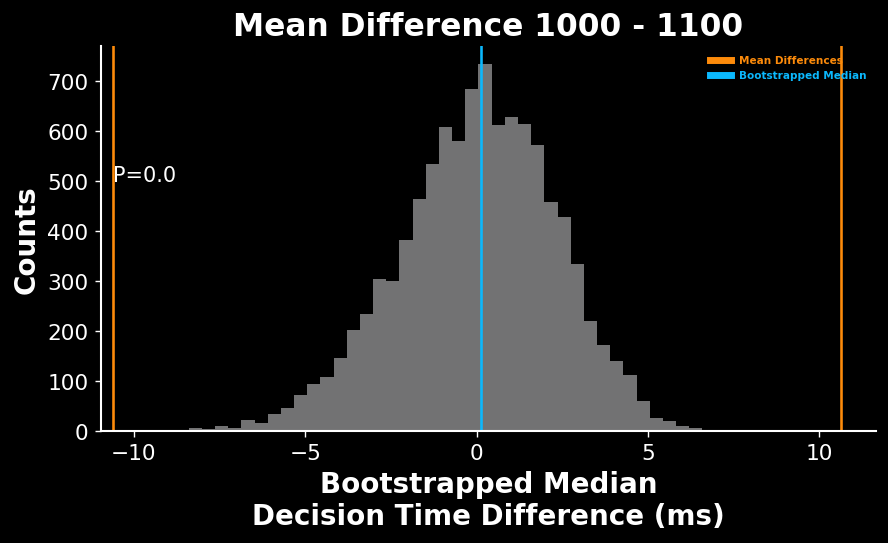

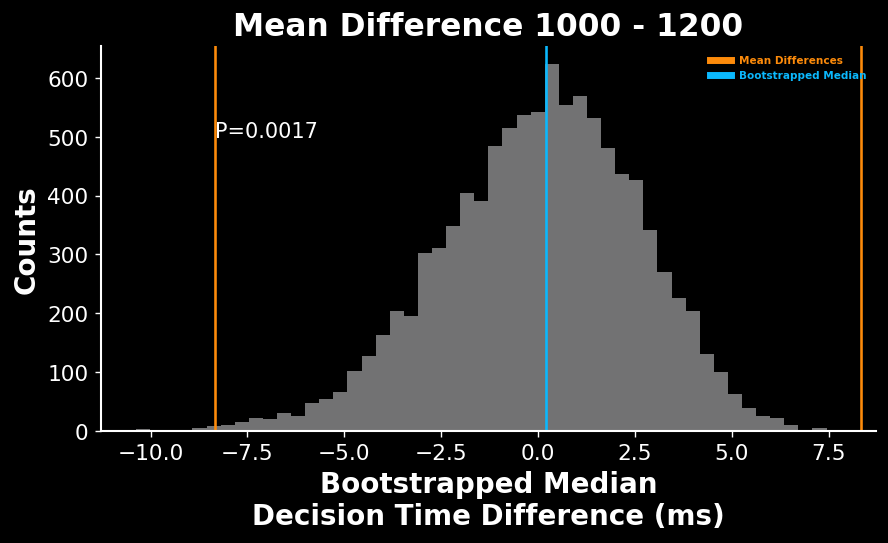

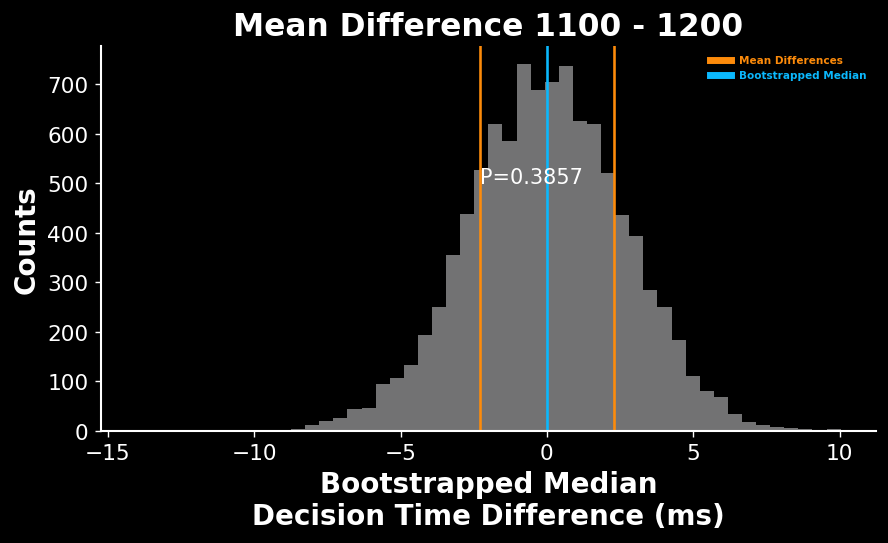

In [208]:
metric = group.combine_all_subjects('player_perc_indecisions')
bootstrap(metric)

#### Incorrects

In [209]:
pg.rm_anova(data=df, dv='Incorrects', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,5961.354167,2,38,2980.677083,29.732602,1.689452e-08,1.472497e-07,0.246094,0.854052
1,Condition SD,151.875000,1,19,151.875000,2.377446,1.395897e-01,1.395897e-01,0.008248,1.000000
2,Condition Mean * Condition SD,564.687500,2,38,282.343750,3.730631,3.316652e-02,4.184158e-02,0.029993,0.840582


[0.0062 0.     0.    ]


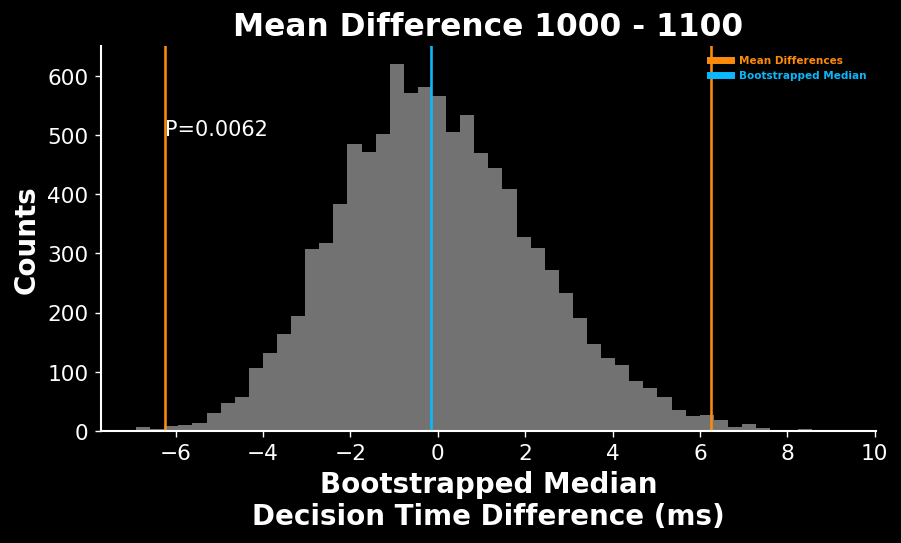

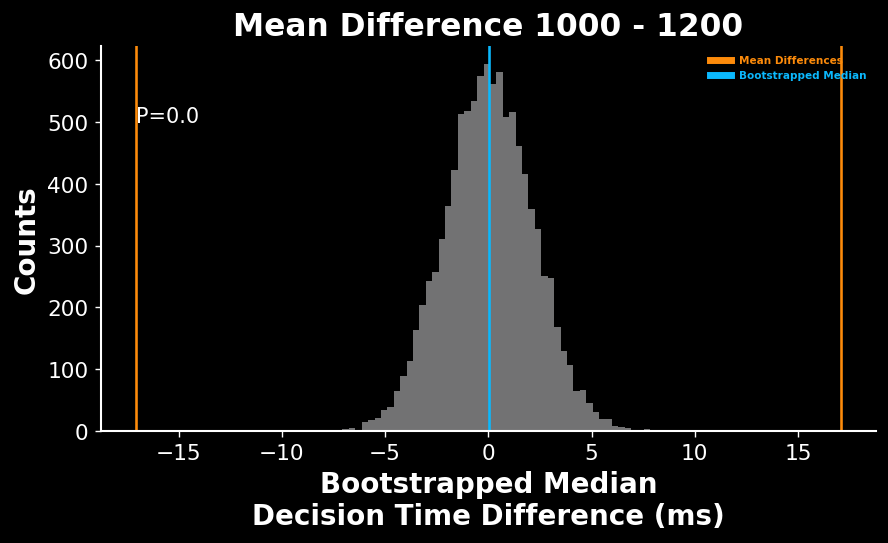

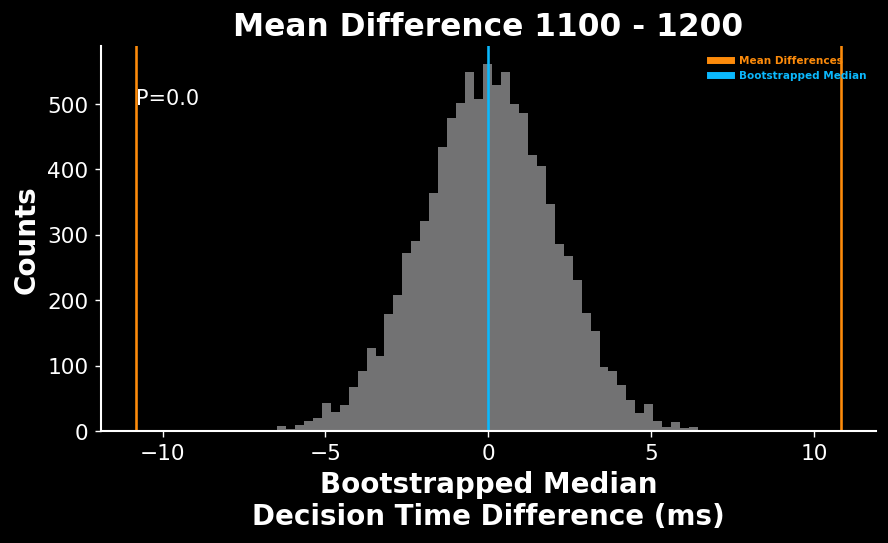

In [210]:
metric = group.combine_all_subjects('player_perc_incorrects')
bootstrap(metric)

Player Minus Agent Task Decision Time Mean